In [1]:
from datetime import datetime, timedelta, date
import pandas as pd
from constants import *
import series as s
from download import query_phe as query, download_phe as download, find_latest
from phe import plot_summary, read_csv, load_population, current_and_previous_data
from plotting import per1m_formatter, per1k_formatter, per0k_formatter
from vaccination import vaccination_dashboard, vaccination_changes
import requests

In [6]:
release=None

In [4]:
overview_data = query(
    filters={area_type: overview},
    structure=[release_timestamp, date_col, area_name, area_code,
               new_cases_by_specimen_date, new_admissions, new_deaths_by_death_date,
               new_virus_tests]
)
overview_data

,releaseTimestamp,date,areaName,areaCode,newCasesBySpecimenDate,newAdmissions,newDeaths28DaysByDeathDate,newVirusTests
0,2021-02-07,2021-02-06,United Kingdom,K02000001,2424,NaN,95.0,NaN
1,2021-02-07,2021-02-05,United Kingdom,K02000001,12268,NaN,383.0,NaN
2,2021-02-07,2021-02-04,United Kingdom,K02000001,17024,NaN,561.0,783851.0
3,2021-02-07,2021-02-03,United Kingdom,K02000001,19194,2332.0,716.0,801949.0
4,2021-02-07,2021-02-02,United Kingdom,K02000001,19660,2461.0,750.0,606382.0
...,...,...,...,...,...,...,...,...
369,2021-02-07,2020-02-03,United Kingdom,K02000001,0,NaN,NaN,NaN
370,2021-02-07,2020-02-02,United Kingdom,K02000001,1,NaN,NaN,NaN
371,2021-02-07,2020-02-01,United Kingdom,K02000001,1,NaN,NaN,NaN
372,2021-02-07,2020-01-31,United Kingdom,K02000001,2,NaN,NaN,NaN


In [7]:
download('england', 'nation', new_admissions_sum, new_cases_sum, new_deaths_sum, unique_people_tested_sum, area_name='England', release=release)

PosixPath('/Users/chris/coronavirus/data/england_2021-02-07.csv')

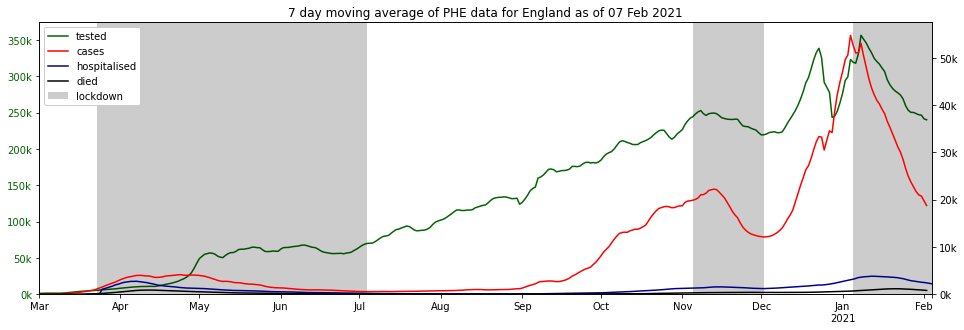

In [8]:
plot_summary(earliest_date='2020-03-01')

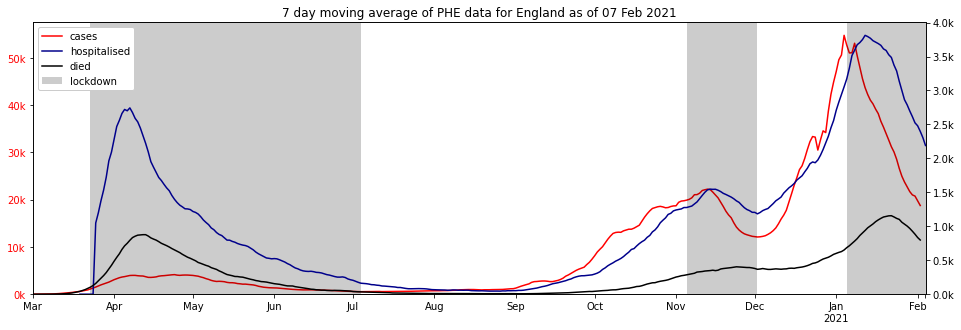

In [9]:
plot_summary(earliest_date='2020-03-01', left_series=(s.new_cases_sum,), 
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

In [10]:
download('vaccination', 'nation', *vaccination_new_and_weekly, release=release)

PosixPath('/Users/chris/coronavirus/data/vaccination_2021-02-07.csv')

In [11]:
download('vaccination_cum', 'nation', *vaccination_cumulative, release=release)

PosixPath('/Users/chris/coronavirus/data/vaccination_cum_2021-02-07.csv')

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,471324.0,10290215.0,9818891.0,56286961,0.837359,17.444344,81.718297
1,Northern Ireland,N92000002,26935.0,295185.0,268250.0,1893667,1.422373,14.165637,84.411990
2,Scotland,S92000003,10710.0,839266.0,828556.0,5463300,0.196035,15.165852,84.638112
3,Wales,W92000004,2606.0,589622.0,587016.0,3152879,0.082655,18.618412,81.298933


'partial: 12,014,288'

'full: 511,575'

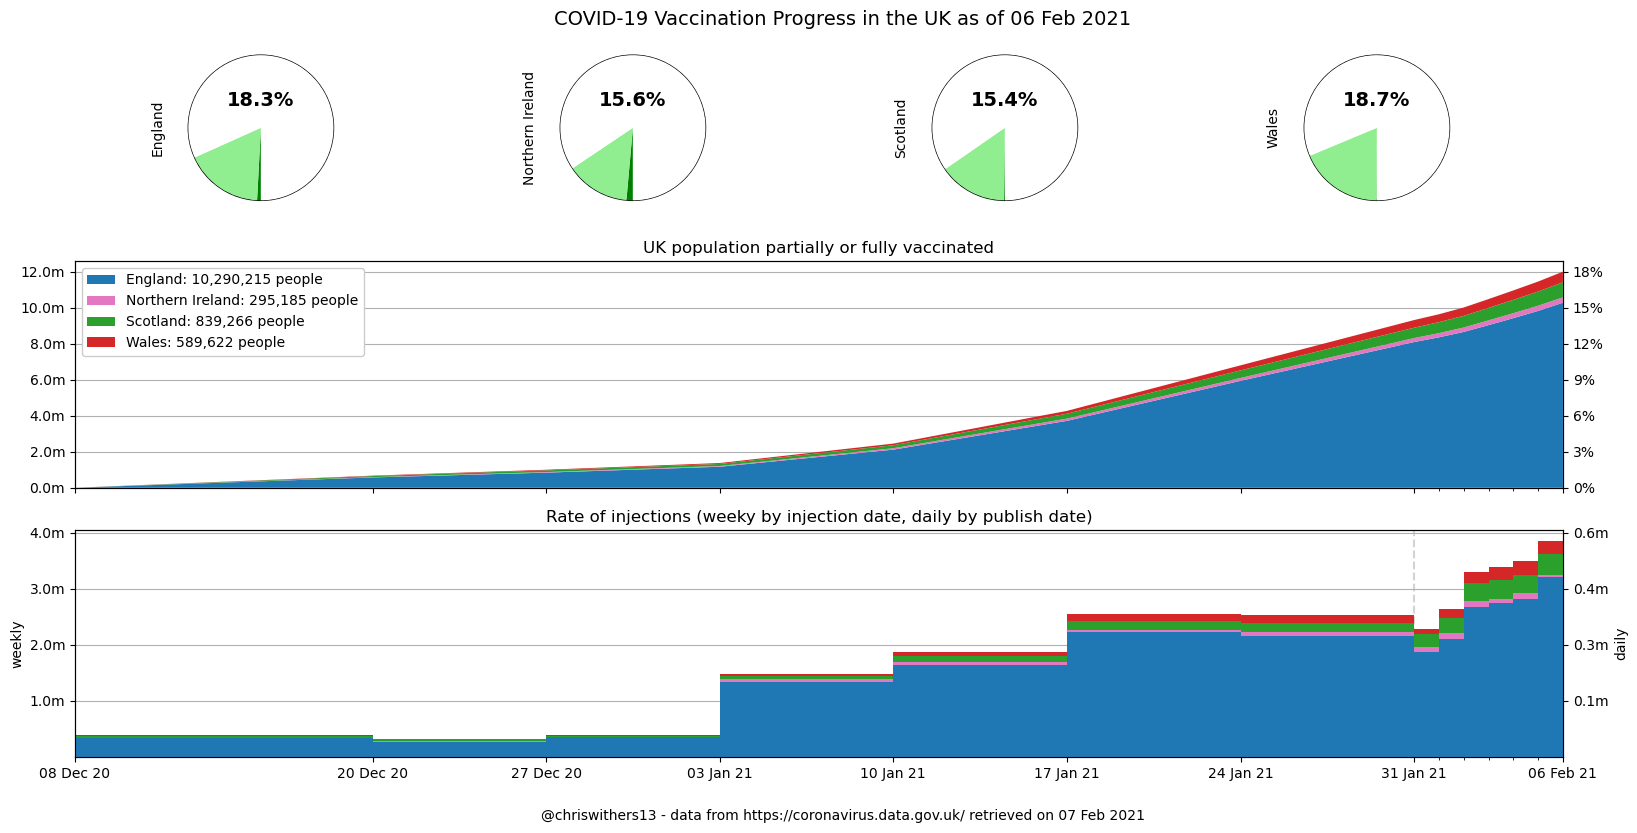

In [12]:
results = vaccination_dashboard()
display(results, f"partial: {results['any'].sum():,.0f}", f"full: {results['full'].sum():,.0f}")

In [13]:
vaccination_changes()

,,First Dose (New),Second Dose (Total),Complete (New),First Dose (Total),cumPeopleVaccinatedSecondDoseByPublishDate,Complete (Total)
,,,,,,,
England,06 Feb 21,"+458,318",+601,+601,"+10,290,215","+471,324","+471,324"
Northern Ireland,06 Feb 21,"+5,296",+404,+404,"+295,185","+26,935","+26,935"
Scotland,06 Feb 21,"+52,839",+250,+250,"+839,266","+10,582","+10,582"
Wales,06 Feb 21,"+32,625",+135,+135,"+589,622","+2,606","+2,606"


In [14]:
download(nation, nation, new_admissions, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/nation_2021-02-07.csv')

In [15]:
download(region, region, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/region_2021-02-07.csv')

In [16]:
download(ltla, ltla, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/ltla_2021-02-07.csv')